# DDQN Assignment


In this homework, you are going to implement DDQN for two Gym environments you choose. One of them should be cart-pole. Here are the exploration tasks for this assignment.

For each game environment:
 - 1)	Experiment with adjusting the size of the replay buffer for training, how often the old records are deleted from the replay buffer, the interval between each update of the target neural network, and the usual Q learning parameters, e.g., gamma and epsilon.
 - 2)	Compare the results with your best performance model from previous homework


Turn in:
 - 1) the entire project with a readme file for how to run your code
 - 2) report from your explorations
 - 3) discussions on the results of your exploration. In particular, compared the results you got with your previous results using GA, and table based Q learning.


# README

Currently revising this report for resubmission

In [ ]:
!pip install gymnasium

In [ ]:
#Imports
import gymnasium
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
#Neural Network Setup
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity, storage_saturation):
      #set up storage for the buffer and the saturation for the deque

        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity

        if storage_saturation > 1: #just for safety's sake
            storage_saturation = 1

        self.storage_saturation = storage_saturation

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

        storage_saturation = 1 * np.random.uniform(self.storage_saturation, 1.0) #the lower the saturation, the more often old data is removed.

        #if we are over a random percentage of the capacity, remove the oldest data points
        if (len(self.buffer) / self.capacity) > storage_saturation:
            self.buffer.popleft()

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

In [ ]:
class DDQNAgent:
    def __init__(self, env, obs_shape, learning_rate=0.001, gamma=0.99, buffer_capacity=5000, buffer_saturation=.99, batch_size=64, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, update_target_freq=1000):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.buffer = ReplayBuffer(buffer_capacity, buffer_saturation)
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.update_target_freq = update_target_freq
        self.learn_step_counter = 0  # Counts how many times we've learned

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(obs_shape, env.action_space.n).to(self.device)
        self.target_model = DQN(obs_shape, env.action_space.n).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).to(self.device)
        q_values = self.model(state)
        return np.argmax(q_values.cpu().detach().numpy())

    def learn(self):
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.model(states)
        next_q_values = self.model(next_states)
        next_q_values_target = self.target_model(next_states)

        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # DDQN: Use the online network to select the action, but the target network to evaluate the Q-value
        next_actions = next_q_values.max(1)[1]
        next_q_value = next_q_values_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)

        expected_q_value = rewards + self.gamma * next_q_value * (1 - dones)

        loss = self.criterion(q_value, expected_q_value)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learn_step_counter += 1
        if self.learn_step_counter % self.update_target_freq == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


## Cartpole Experiments

In [ ]:
def run_cartpole_experiment(num_episodes, learning_rate=0.001, gamma=0.99, buffer_capacity=5000, buffer_saturation=.99, batch_size=64, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, update_target_freq=1000):

  import matplotlib.pyplot as plt

  env = gym.make('CartPole-v1')
  agent = DDQNAgent(env, env.observation_space.shape[0], learning_rate, gamma, buffer_capacity, buffer_saturation, batch_size, epsilon, epsilon_decay, epsilon_min, update_target_freq)

  num_episodes = num_episodes

  scores = np.array([])

  running_average = 0

  for episode in range(1, num_episodes+1):
      state = env.reset()
      done = False
      total_reward = 0
      while not done:
          action = agent.act(state)
          next_state, reward, done, _ = env.step(action)
          agent.buffer.push(state, action, reward, next_state, done)
          agent.learn()
          state = next_state
          total_reward += reward

      running_average += total_reward

      if episode % 50 == 0:
        print(f"Episode: {episode}, Running Average (last 50 episodes): {running_average/50}")
        running_average = 0
      scores = np.append(scores, total_reward)

  env.close()

  plt.plot(scores)
  plt.xlabel("Episodes")
  plt.ylabel("Total Reward")
  plt.title("CartPole Experiment Scores")
  plt.show()

  return agent

# print(f"Scores:\n {scores}")


Experiment: 1
Replay Buffer Size: 100, Buffer Saturation: 0.5, Interval: 100, Epsilon: 0.001, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 29.26
Episode: 100, Running Average (last 50 episodes): 171.48
Episode: 150, Running Average (last 50 episodes): 176.74
Episode: 200, Running Average (last 50 episodes): 47.56
Episode: 250, Running Average (last 50 episodes): 134.52
Episode: 300, Running Average (last 50 episodes): 122.56
Episode: 350, Running Average (last 50 episodes): 145.08
Episode: 400, Running Average (last 50 episodes): 67.56
Episode: 450, Running Average (last 50 episodes): 131.5
Episode: 500, Running Average (last 50 episodes): 169.8
Episode: 550, Running Average (last 50 episodes): 153.46
Episode: 600, Running Average (last 50 episodes): 237.1
Episode: 650, Running Average (last 50 episodes): 73.9
Episode: 700, Running Average (last 50 episodes): 254.64
Episode: 750, Running Average (last 50 episodes): 194.02
Episode: 800, Running Average (last 50 episodes)

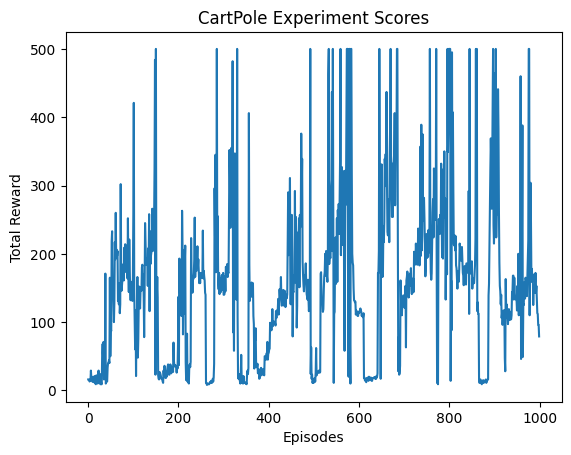


Experiment: 2
Replay Buffer Size: 100, Buffer Saturation: 0.5, Interval: 100, Epsilon: 0.001, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 17.24
Episode: 100, Running Average (last 50 episodes): 25.56
Episode: 150, Running Average (last 50 episodes): 85.66
Episode: 200, Running Average (last 50 episodes): 265.2
Episode: 250, Running Average (last 50 episodes): 311.64
Episode: 300, Running Average (last 50 episodes): 365.3
Episode: 350, Running Average (last 50 episodes): 314.92
Episode: 400, Running Average (last 50 episodes): 231.86
Episode: 450, Running Average (last 50 episodes): 297.22
Episode: 500, Running Average (last 50 episodes): 276.48
Episode: 550, Running Average (last 50 episodes): 314.8
Episode: 600, Running Average (last 50 episodes): 231.4
Episode: 650, Running Average (last 50 episodes): 266.56
Episode: 700, Running Average (last 50 episodes): 252.88
Episode: 750, Running Average (last 50 episodes): 269.38
Episode: 800, Running Average (last 50 episode

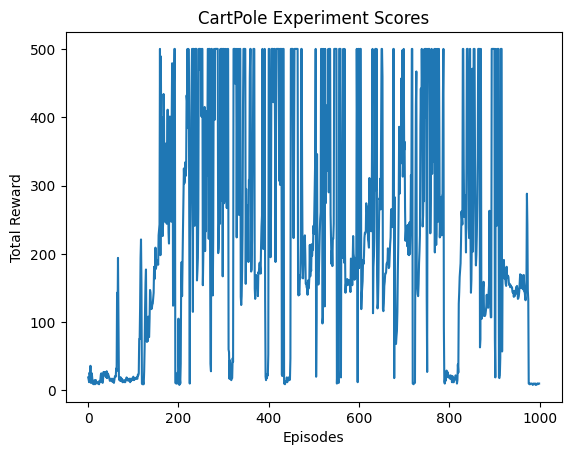


Experiment: 3
Replay Buffer Size: 100, Buffer Saturation: 0.5, Interval: 100, Epsilon: 0.1, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 72.04
Episode: 100, Running Average (last 50 episodes): 177.86
Episode: 150, Running Average (last 50 episodes): 177.68
Episode: 200, Running Average (last 50 episodes): 150.46
Episode: 250, Running Average (last 50 episodes): 160.76
Episode: 300, Running Average (last 50 episodes): 173.28
Episode: 350, Running Average (last 50 episodes): 162.3
Episode: 400, Running Average (last 50 episodes): 170.66
Episode: 450, Running Average (last 50 episodes): 147.98
Episode: 500, Running Average (last 50 episodes): 174.84
Episode: 550, Running Average (last 50 episodes): 172.72
Episode: 600, Running Average (last 50 episodes): 137.48
Episode: 650, Running Average (last 50 episodes): 167.48
Episode: 700, Running Average (last 50 episodes): 158.56
Episode: 750, Running Average (last 50 episodes): 80.16
Episode: 800, Running Average (last 50 episod

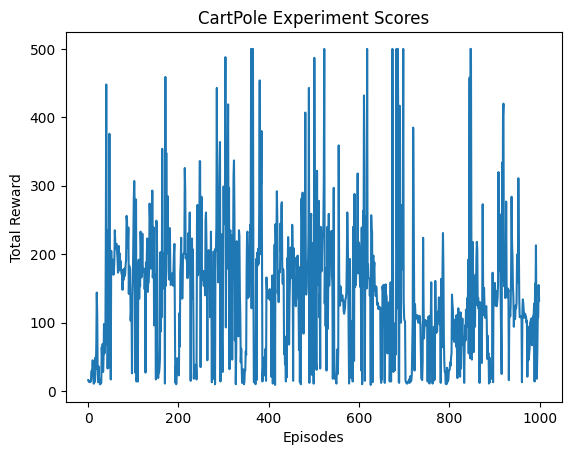


Experiment: 4
Replay Buffer Size: 100, Buffer Saturation: 0.5, Interval: 100, Epsilon: 0.1, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 49.86
Episode: 100, Running Average (last 50 episodes): 146.12
Episode: 150, Running Average (last 50 episodes): 260.92
Episode: 200, Running Average (last 50 episodes): 282.6
Episode: 250, Running Average (last 50 episodes): 350.6
Episode: 300, Running Average (last 50 episodes): 358.68
Episode: 350, Running Average (last 50 episodes): 320.16
Episode: 400, Running Average (last 50 episodes): 206.3
Episode: 450, Running Average (last 50 episodes): 231.02
Episode: 500, Running Average (last 50 episodes): 211.08
Episode: 550, Running Average (last 50 episodes): 278.24
Episode: 600, Running Average (last 50 episodes): 268.28
Episode: 650, Running Average (last 50 episodes): 184.24
Episode: 700, Running Average (last 50 episodes): 300.34
Episode: 750, Running Average (last 50 episodes): 210.38
Episode: 800, Running Average (last 50 episod

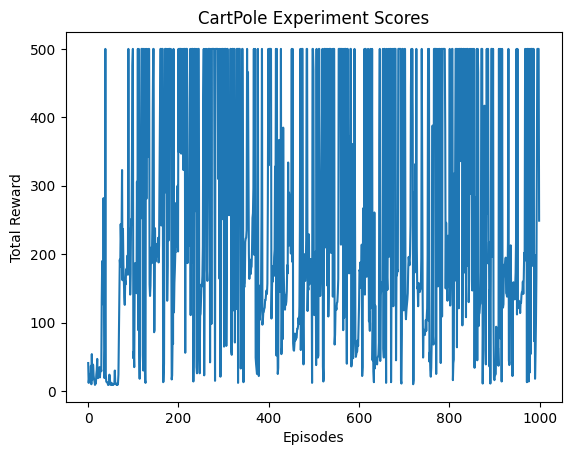


Experiment: 5
Replay Buffer Size: 100, Buffer Saturation: 0.5, Interval: 500, Epsilon: 0.001, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 13.22
Episode: 100, Running Average (last 50 episodes): 9.48
Episode: 150, Running Average (last 50 episodes): 9.52
Episode: 200, Running Average (last 50 episodes): 9.58
Episode: 250, Running Average (last 50 episodes): 9.56
Episode: 300, Running Average (last 50 episodes): 9.36
Episode: 350, Running Average (last 50 episodes): 9.4
Episode: 400, Running Average (last 50 episodes): 9.26
Episode: 450, Running Average (last 50 episodes): 9.2
Episode: 500, Running Average (last 50 episodes): 9.36
Episode: 550, Running Average (last 50 episodes): 9.02
Episode: 600, Running Average (last 50 episodes): 9.3
Episode: 650, Running Average (last 50 episodes): 9.46
Episode: 700, Running Average (last 50 episodes): 9.24
Episode: 750, Running Average (last 50 episodes): 10.04
Episode: 800, Running Average (last 50 episodes): 19.94
Episode: 850, R

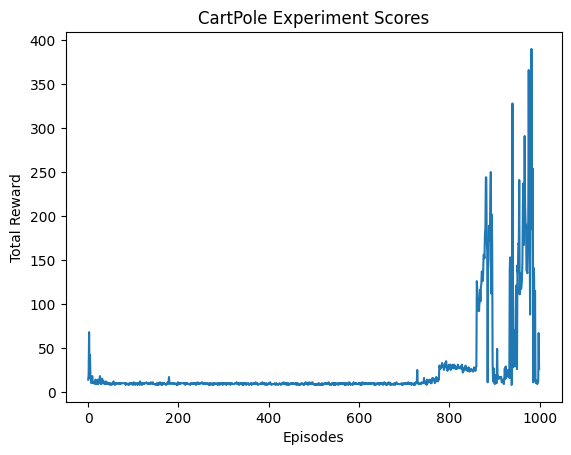


Experiment: 6
Replay Buffer Size: 100, Buffer Saturation: 0.5, Interval: 500, Epsilon: 0.001, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 20.76
Episode: 100, Running Average (last 50 episodes): 24.32
Episode: 150, Running Average (last 50 episodes): 97.2
Episode: 200, Running Average (last 50 episodes): 123.4
Episode: 250, Running Average (last 50 episodes): 13.66
Episode: 300, Running Average (last 50 episodes): 108.8
Episode: 350, Running Average (last 50 episodes): 144.2
Episode: 400, Running Average (last 50 episodes): 60.04
Episode: 450, Running Average (last 50 episodes): 131.88
Episode: 500, Running Average (last 50 episodes): 259.4
Episode: 550, Running Average (last 50 episodes): 69.48
Episode: 600, Running Average (last 50 episodes): 9.2
Episode: 650, Running Average (last 50 episodes): 9.3
Episode: 700, Running Average (last 50 episodes): 9.3
Episode: 750, Running Average (last 50 episodes): 9.22
Episode: 800, Running Average (last 50 episodes): 9.28
Episod

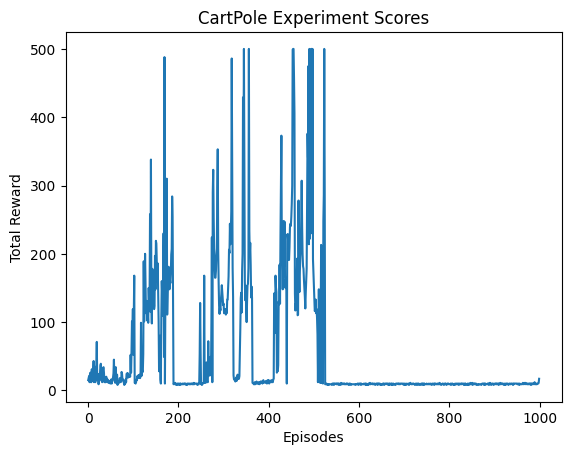


Experiment: 7
Replay Buffer Size: 100, Buffer Saturation: 0.5, Interval: 500, Epsilon: 0.1, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 13.9
Episode: 100, Running Average (last 50 episodes): 10.46
Episode: 150, Running Average (last 50 episodes): 15.64
Episode: 200, Running Average (last 50 episodes): 100.94
Episode: 250, Running Average (last 50 episodes): 53.96
Episode: 300, Running Average (last 50 episodes): 163.66
Episode: 350, Running Average (last 50 episodes): 133.7
Episode: 400, Running Average (last 50 episodes): 141.76
Episode: 450, Running Average (last 50 episodes): 144.6
Episode: 500, Running Average (last 50 episodes): 145.08
Episode: 550, Running Average (last 50 episodes): 148.58
Episode: 600, Running Average (last 50 episodes): 116.22
Episode: 650, Running Average (last 50 episodes): 123.64
Episode: 700, Running Average (last 50 episodes): 91.18
Episode: 750, Running Average (last 50 episodes): 122.42
Episode: 800, Running Average (last 50 episodes): 

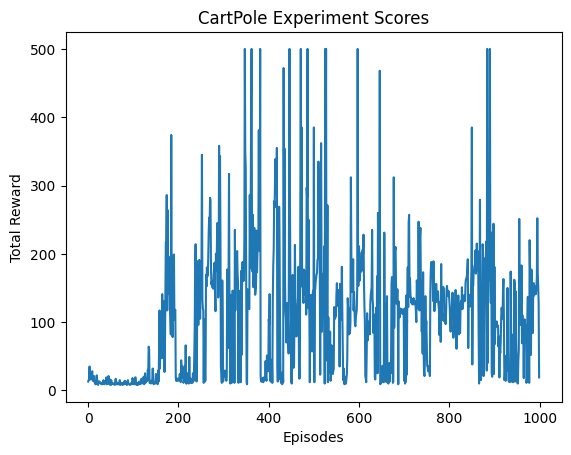


Experiment: 8
Replay Buffer Size: 100, Buffer Saturation: 0.5, Interval: 500, Epsilon: 0.1, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 13.76
Episode: 100, Running Average (last 50 episodes): 11.76
Episode: 150, Running Average (last 50 episodes): 36.2
Episode: 200, Running Average (last 50 episodes): 133.74
Episode: 250, Running Average (last 50 episodes): 151.26
Episode: 300, Running Average (last 50 episodes): 191.54
Episode: 350, Running Average (last 50 episodes): 136.32
Episode: 400, Running Average (last 50 episodes): 259.26
Episode: 450, Running Average (last 50 episodes): 181.8
Episode: 500, Running Average (last 50 episodes): 223.64
Episode: 550, Running Average (last 50 episodes): 291.48
Episode: 600, Running Average (last 50 episodes): 177.26
Episode: 650, Running Average (last 50 episodes): 173.36
Episode: 700, Running Average (last 50 episodes): 197.32
Episode: 750, Running Average (last 50 episodes): 27.34
Episode: 800, Running Average (last 50 episodes

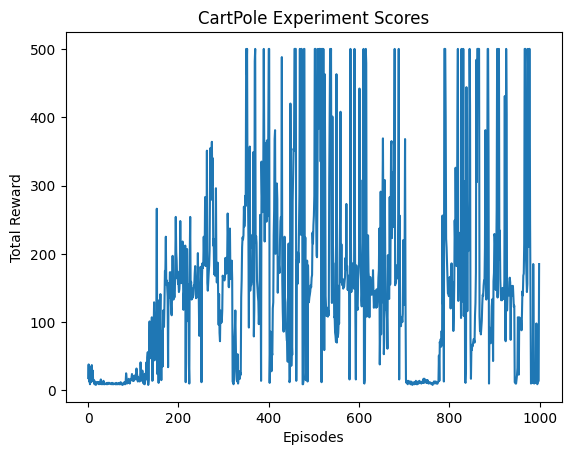


Experiment: 9
Replay Buffer Size: 100, Buffer Saturation: 0.9, Interval: 100, Epsilon: 0.001, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 54.12
Episode: 100, Running Average (last 50 episodes): 154.26
Episode: 150, Running Average (last 50 episodes): 141.42
Episode: 200, Running Average (last 50 episodes): 151.64
Episode: 250, Running Average (last 50 episodes): 167.14
Episode: 300, Running Average (last 50 episodes): 160.14
Episode: 350, Running Average (last 50 episodes): 172.02
Episode: 400, Running Average (last 50 episodes): 233.5
Episode: 450, Running Average (last 50 episodes): 189.34
Episode: 500, Running Average (last 50 episodes): 97.66
Episode: 550, Running Average (last 50 episodes): 161.12
Episode: 600, Running Average (last 50 episodes): 217.96
Episode: 650, Running Average (last 50 episodes): 164.54
Episode: 700, Running Average (last 50 episodes): 106.72
Episode: 750, Running Average (last 50 episodes): 65.26
Episode: 800, Running Average (last 50 episo

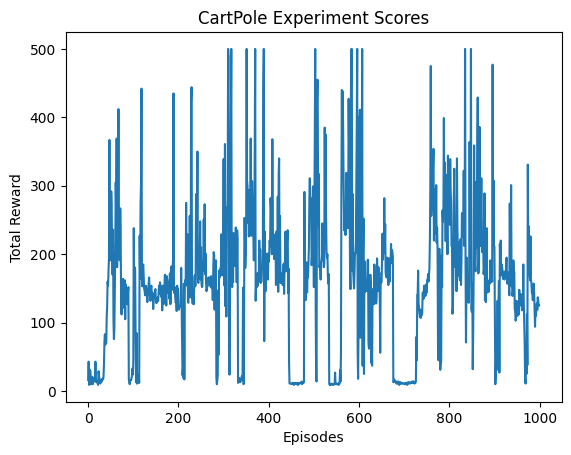


Experiment: 10
Replay Buffer Size: 100, Buffer Saturation: 0.9, Interval: 100, Epsilon: 0.001, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 51.6
Episode: 100, Running Average (last 50 episodes): 163.14
Episode: 150, Running Average (last 50 episodes): 58.5
Episode: 200, Running Average (last 50 episodes): 58.0
Episode: 250, Running Average (last 50 episodes): 266.36
Episode: 300, Running Average (last 50 episodes): 209.2
Episode: 350, Running Average (last 50 episodes): 299.42
Episode: 400, Running Average (last 50 episodes): 370.6
Episode: 450, Running Average (last 50 episodes): 387.7
Episode: 500, Running Average (last 50 episodes): 368.0
Episode: 550, Running Average (last 50 episodes): 298.84
Episode: 600, Running Average (last 50 episodes): 357.56
Episode: 650, Running Average (last 50 episodes): 282.52
Episode: 700, Running Average (last 50 episodes): 267.14
Episode: 750, Running Average (last 50 episodes): 229.7
Episode: 800, Running Average (last 50 episodes):

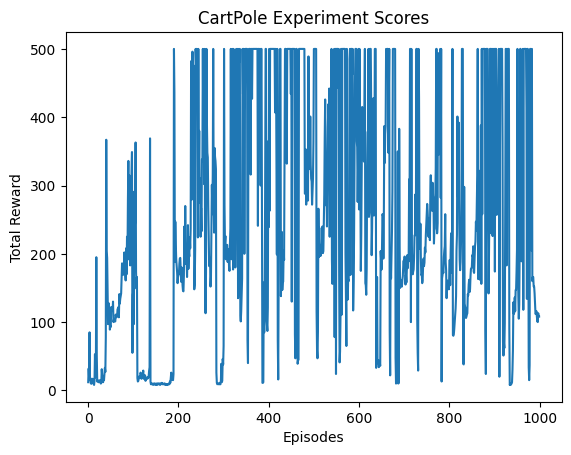


Experiment: 11
Replay Buffer Size: 100, Buffer Saturation: 0.9, Interval: 100, Epsilon: 0.1, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 36.62
Episode: 100, Running Average (last 50 episodes): 117.14
Episode: 150, Running Average (last 50 episodes): 117.02
Episode: 200, Running Average (last 50 episodes): 193.48
Episode: 250, Running Average (last 50 episodes): 141.78
Episode: 300, Running Average (last 50 episodes): 189.96
Episode: 350, Running Average (last 50 episodes): 152.02
Episode: 400, Running Average (last 50 episodes): 157.52
Episode: 450, Running Average (last 50 episodes): 161.3
Episode: 500, Running Average (last 50 episodes): 125.72
Episode: 550, Running Average (last 50 episodes): 176.4
Episode: 600, Running Average (last 50 episodes): 149.8
Episode: 650, Running Average (last 50 episodes): 127.94
Episode: 700, Running Average (last 50 episodes): 185.26
Episode: 750, Running Average (last 50 episodes): 241.12
Episode: 800, Running Average (last 50 episod

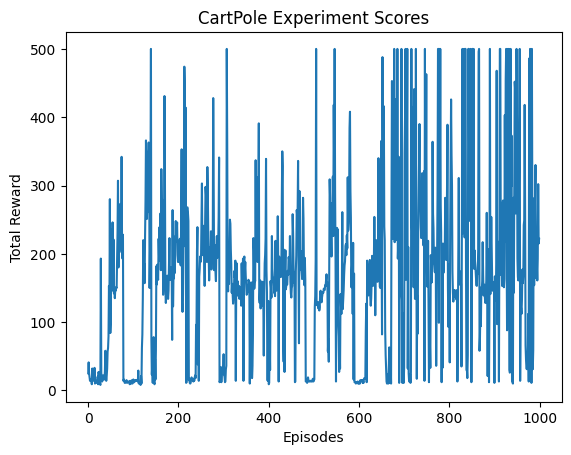


Experiment: 12
Replay Buffer Size: 100, Buffer Saturation: 0.9, Interval: 100, Epsilon: 0.1, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 27.82
Episode: 100, Running Average (last 50 episodes): 130.42
Episode: 150, Running Average (last 50 episodes): 157.9
Episode: 200, Running Average (last 50 episodes): 217.1
Episode: 250, Running Average (last 50 episodes): 306.04
Episode: 300, Running Average (last 50 episodes): 341.62
Episode: 350, Running Average (last 50 episodes): 389.5
Episode: 400, Running Average (last 50 episodes): 301.94
Episode: 450, Running Average (last 50 episodes): 308.12
Episode: 500, Running Average (last 50 episodes): 186.14
Episode: 550, Running Average (last 50 episodes): 185.96
Episode: 600, Running Average (last 50 episodes): 218.5
Episode: 650, Running Average (last 50 episodes): 242.5
Episode: 700, Running Average (last 50 episodes): 236.22
Episode: 750, Running Average (last 50 episodes): 257.5
Episode: 800, Running Average (last 50 episodes

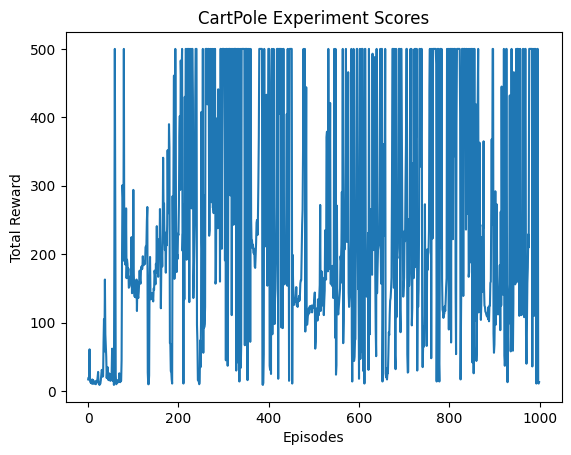


Experiment: 13
Replay Buffer Size: 100, Buffer Saturation: 0.9, Interval: 500, Epsilon: 0.001, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 13.62
Episode: 100, Running Average (last 50 episodes): 13.2
Episode: 150, Running Average (last 50 episodes): 10.0
Episode: 200, Running Average (last 50 episodes): 9.28
Episode: 250, Running Average (last 50 episodes): 9.38
Episode: 300, Running Average (last 50 episodes): 9.44
Episode: 350, Running Average (last 50 episodes): 9.54
Episode: 400, Running Average (last 50 episodes): 9.44
Episode: 450, Running Average (last 50 episodes): 9.34
Episode: 500, Running Average (last 50 episodes): 9.4
Episode: 550, Running Average (last 50 episodes): 9.26
Episode: 600, Running Average (last 50 episodes): 9.14
Episode: 650, Running Average (last 50 episodes): 9.4
Episode: 700, Running Average (last 50 episodes): 9.38
Episode: 750, Running Average (last 50 episodes): 9.14
Episode: 800, Running Average (last 50 episodes): 9.42
Episode: 850, R

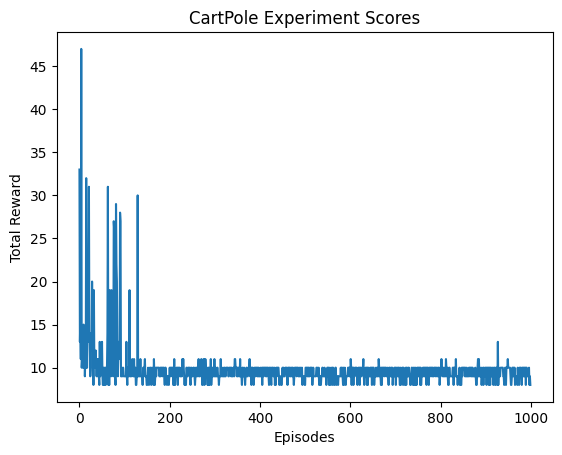


Experiment: 14
Replay Buffer Size: 100, Buffer Saturation: 0.9, Interval: 500, Epsilon: 0.001, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 12.78
Episode: 100, Running Average (last 50 episodes): 9.98
Episode: 150, Running Average (last 50 episodes): 16.02
Episode: 200, Running Average (last 50 episodes): 13.6
Episode: 250, Running Average (last 50 episodes): 9.2
Episode: 300, Running Average (last 50 episodes): 9.2
Episode: 350, Running Average (last 50 episodes): 9.5
Episode: 400, Running Average (last 50 episodes): 9.26
Episode: 450, Running Average (last 50 episodes): 9.26
Episode: 500, Running Average (last 50 episodes): 9.38
Episode: 550, Running Average (last 50 episodes): 9.4
Episode: 600, Running Average (last 50 episodes): 9.26
Episode: 650, Running Average (last 50 episodes): 9.16
Episode: 700, Running Average (last 50 episodes): 9.26
Episode: 750, Running Average (last 50 episodes): 9.36
Episode: 800, Running Average (last 50 episodes): 9.38
Episode: 850, R

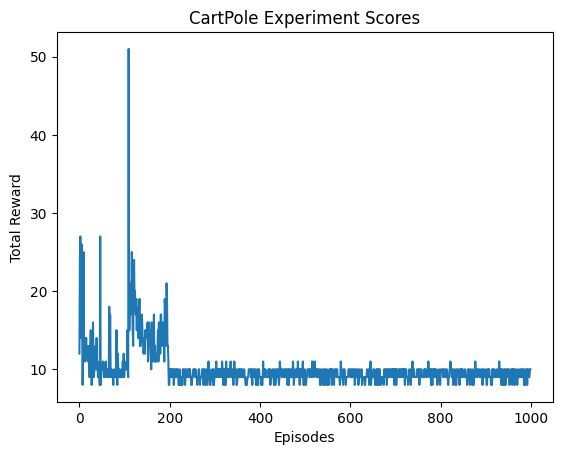


Experiment: 15
Replay Buffer Size: 100, Buffer Saturation: 0.9, Interval: 500, Epsilon: 0.1, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 40.62
Episode: 100, Running Average (last 50 episodes): 81.74
Episode: 150, Running Average (last 50 episodes): 115.64
Episode: 200, Running Average (last 50 episodes): 73.88
Episode: 250, Running Average (last 50 episodes): 171.36
Episode: 300, Running Average (last 50 episodes): 213.42
Episode: 350, Running Average (last 50 episodes): 134.04
Episode: 400, Running Average (last 50 episodes): 110.48
Episode: 450, Running Average (last 50 episodes): 188.44
Episode: 500, Running Average (last 50 episodes): 128.68
Episode: 550, Running Average (last 50 episodes): 85.58
Episode: 600, Running Average (last 50 episodes): 177.32
Episode: 650, Running Average (last 50 episodes): 188.8
Episode: 700, Running Average (last 50 episodes): 96.0
Episode: 750, Running Average (last 50 episodes): 68.52
Episode: 800, Running Average (last 50 episodes):

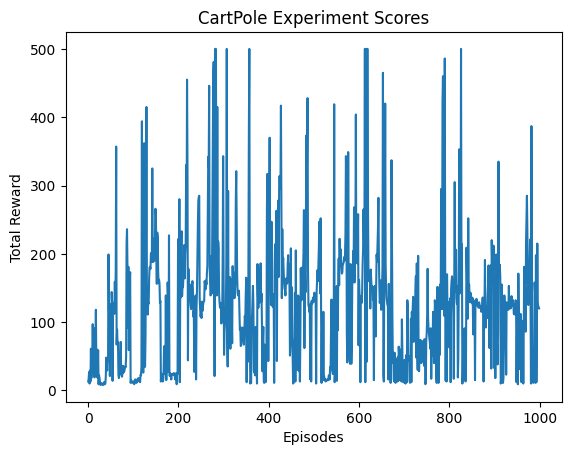


Experiment: 16
Replay Buffer Size: 100, Buffer Saturation: 0.9, Interval: 500, Epsilon: 0.1, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 13.04
Episode: 100, Running Average (last 50 episodes): 18.82
Episode: 150, Running Average (last 50 episodes): 69.82
Episode: 200, Running Average (last 50 episodes): 17.12
Episode: 250, Running Average (last 50 episodes): 117.58
Episode: 300, Running Average (last 50 episodes): 145.54
Episode: 350, Running Average (last 50 episodes): 180.92
Episode: 400, Running Average (last 50 episodes): 152.84
Episode: 450, Running Average (last 50 episodes): 175.66
Episode: 500, Running Average (last 50 episodes): 150.38
Episode: 550, Running Average (last 50 episodes): 163.2
Episode: 600, Running Average (last 50 episodes): 140.72
Episode: 650, Running Average (last 50 episodes): 200.78
Episode: 700, Running Average (last 50 episodes): 100.86
Episode: 750, Running Average (last 50 episodes): 93.56
Episode: 800, Running Average (last 50 episode

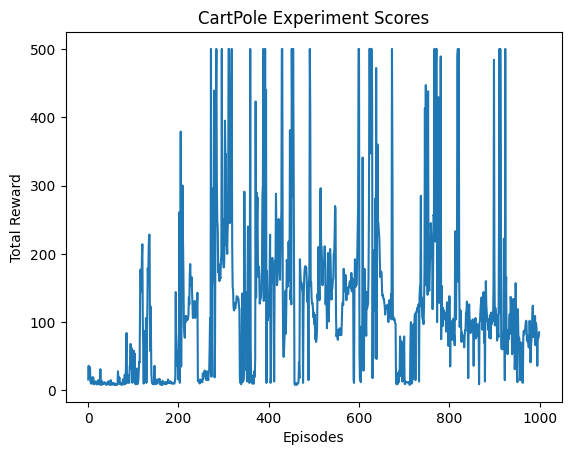


Experiment: 17
Replay Buffer Size: 1000, Buffer Saturation: 0.5, Interval: 100, Epsilon: 0.001, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 93.7
Episode: 100, Running Average (last 50 episodes): 209.16
Episode: 150, Running Average (last 50 episodes): 168.36
Episode: 200, Running Average (last 50 episodes): 272.6
Episode: 250, Running Average (last 50 episodes): 153.86
Episode: 300, Running Average (last 50 episodes): 193.52
Episode: 350, Running Average (last 50 episodes): 185.98
Episode: 400, Running Average (last 50 episodes): 163.42
Episode: 450, Running Average (last 50 episodes): 216.5
Episode: 500, Running Average (last 50 episodes): 98.34
Episode: 550, Running Average (last 50 episodes): 188.22
Episode: 600, Running Average (last 50 episodes): 176.66
Episode: 650, Running Average (last 50 episodes): 142.88
Episode: 700, Running Average (last 50 episodes): 160.42
Episode: 750, Running Average (last 50 episodes): 167.12
Episode: 800, Running Average (last 50 epis

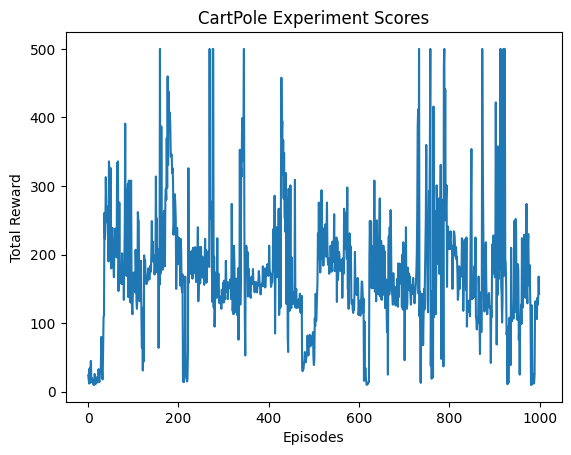


Experiment: 18
Replay Buffer Size: 1000, Buffer Saturation: 0.5, Interval: 100, Epsilon: 0.001, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 140.02
Episode: 100, Running Average (last 50 episodes): 175.6
Episode: 150, Running Average (last 50 episodes): 376.06
Episode: 200, Running Average (last 50 episodes): 314.98
Episode: 250, Running Average (last 50 episodes): 401.52
Episode: 300, Running Average (last 50 episodes): 267.34
Episode: 350, Running Average (last 50 episodes): 392.08
Episode: 400, Running Average (last 50 episodes): 318.42
Episode: 450, Running Average (last 50 episodes): 151.1
Episode: 500, Running Average (last 50 episodes): 351.2
Episode: 550, Running Average (last 50 episodes): 452.72
Episode: 600, Running Average (last 50 episodes): 447.58
Episode: 650, Running Average (last 50 episodes): 356.12
Episode: 700, Running Average (last 50 episodes): 397.18
Episode: 750, Running Average (last 50 episodes): 374.18
Episode: 800, Running Average (last 50 e

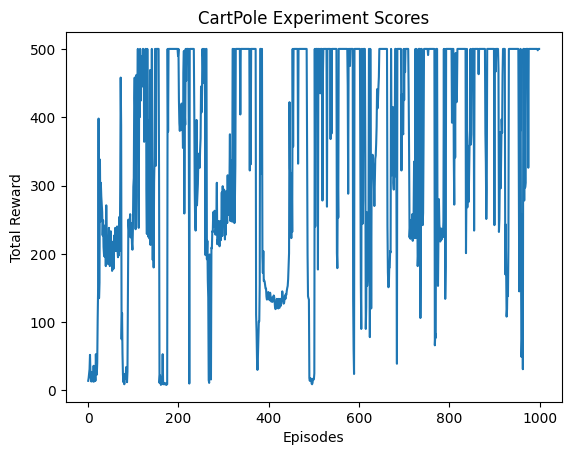


Experiment: 19
Replay Buffer Size: 1000, Buffer Saturation: 0.5, Interval: 100, Epsilon: 0.1, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 134.24
Episode: 100, Running Average (last 50 episodes): 201.16
Episode: 150, Running Average (last 50 episodes): 258.62
Episode: 200, Running Average (last 50 episodes): 188.2
Episode: 250, Running Average (last 50 episodes): 166.02
Episode: 300, Running Average (last 50 episodes): 225.66
Episode: 350, Running Average (last 50 episodes): 181.84
Episode: 400, Running Average (last 50 episodes): 173.06
Episode: 450, Running Average (last 50 episodes): 179.38
Episode: 500, Running Average (last 50 episodes): 152.12
Episode: 550, Running Average (last 50 episodes): 185.26
Episode: 600, Running Average (last 50 episodes): 203.68
Episode: 650, Running Average (last 50 episodes): 155.36
Episode: 700, Running Average (last 50 episodes): 147.54
Episode: 750, Running Average (last 50 episodes): 155.52
Episode: 800, Running Average (last 50 ep

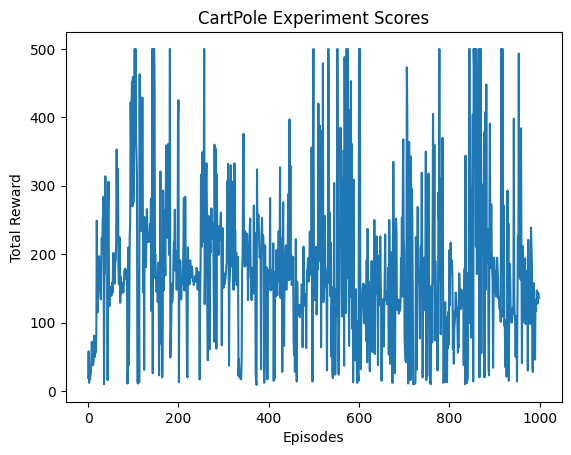


Experiment: 20
Replay Buffer Size: 1000, Buffer Saturation: 0.5, Interval: 100, Epsilon: 0.1, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 131.3
Episode: 100, Running Average (last 50 episodes): 164.0
Episode: 150, Running Average (last 50 episodes): 137.0
Episode: 200, Running Average (last 50 episodes): 295.36
Episode: 250, Running Average (last 50 episodes): 433.1
Episode: 300, Running Average (last 50 episodes): 399.54
Episode: 350, Running Average (last 50 episodes): 352.28
Episode: 400, Running Average (last 50 episodes): 354.2
Episode: 450, Running Average (last 50 episodes): 316.9
Episode: 500, Running Average (last 50 episodes): 423.96
Episode: 550, Running Average (last 50 episodes): 402.68
Episode: 600, Running Average (last 50 episodes): 404.12
Episode: 650, Running Average (last 50 episodes): 297.44
Episode: 700, Running Average (last 50 episodes): 374.44
Episode: 750, Running Average (last 50 episodes): 369.18
Episode: 800, Running Average (last 50 episod

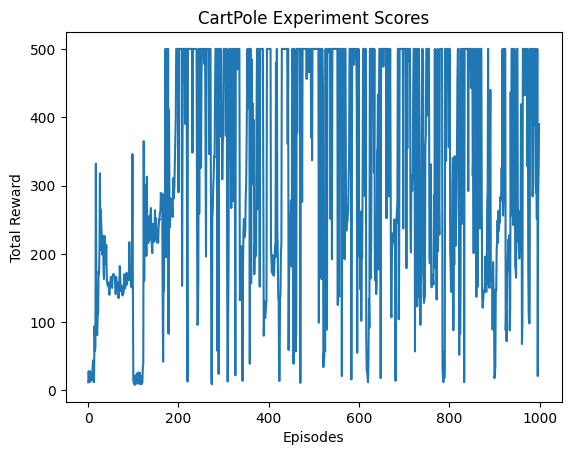


Experiment: 21
Replay Buffer Size: 1000, Buffer Saturation: 0.5, Interval: 500, Epsilon: 0.001, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 20.32
Episode: 100, Running Average (last 50 episodes): 79.54
Episode: 150, Running Average (last 50 episodes): 185.06
Episode: 200, Running Average (last 50 episodes): 160.98
Episode: 250, Running Average (last 50 episodes): 163.34
Episode: 300, Running Average (last 50 episodes): 186.98
Episode: 350, Running Average (last 50 episodes): 257.66
Episode: 400, Running Average (last 50 episodes): 241.86
Episode: 450, Running Average (last 50 episodes): 153.1
Episode: 500, Running Average (last 50 episodes): 217.06
Episode: 550, Running Average (last 50 episodes): 211.64
Episode: 600, Running Average (last 50 episodes): 121.5
Episode: 650, Running Average (last 50 episodes): 217.2
Episode: 700, Running Average (last 50 episodes): 223.0
Episode: 750, Running Average (last 50 episodes): 188.76
Episode: 800, Running Average (last 50 episo

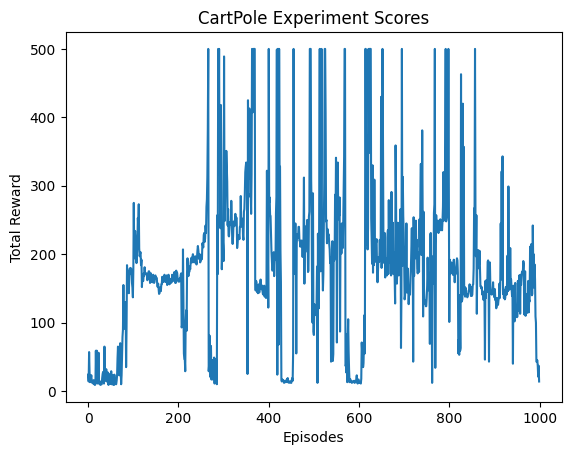


Experiment: 22
Replay Buffer Size: 1000, Buffer Saturation: 0.5, Interval: 500, Epsilon: 0.001, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 16.46
Episode: 100, Running Average (last 50 episodes): 11.98
Episode: 150, Running Average (last 50 episodes): 14.8
Episode: 200, Running Average (last 50 episodes): 142.14
Episode: 250, Running Average (last 50 episodes): 134.52
Episode: 300, Running Average (last 50 episodes): 139.7
Episode: 350, Running Average (last 50 episodes): 141.82
Episode: 400, Running Average (last 50 episodes): 144.06
Episode: 450, Running Average (last 50 episodes): 187.22
Episode: 500, Running Average (last 50 episodes): 144.36
Episode: 550, Running Average (last 50 episodes): 209.8
Episode: 600, Running Average (last 50 episodes): 256.8
Episode: 650, Running Average (last 50 episodes): 210.4
Episode: 700, Running Average (last 50 episodes): 281.2
Episode: 750, Running Average (last 50 episodes): 279.34
Episode: 800, Running Average (last 50 episode

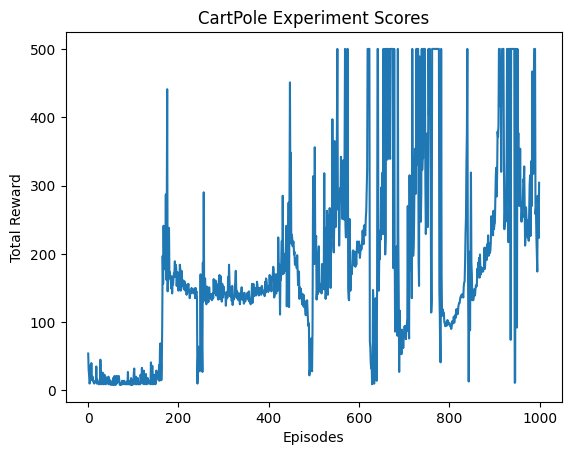


Experiment: 23
Replay Buffer Size: 1000, Buffer Saturation: 0.5, Interval: 500, Epsilon: 0.1, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 15.7
Episode: 100, Running Average (last 50 episodes): 12.28
Episode: 150, Running Average (last 50 episodes): 12.26
Episode: 200, Running Average (last 50 episodes): 57.62
Episode: 250, Running Average (last 50 episodes): 236.38
Episode: 300, Running Average (last 50 episodes): 246.56
Episode: 350, Running Average (last 50 episodes): 213.1
Episode: 400, Running Average (last 50 episodes): 174.68
Episode: 450, Running Average (last 50 episodes): 146.38
Episode: 500, Running Average (last 50 episodes): 180.26
Episode: 550, Running Average (last 50 episodes): 210.12
Episode: 600, Running Average (last 50 episodes): 134.0
Episode: 650, Running Average (last 50 episodes): 92.14
Episode: 700, Running Average (last 50 episodes): 115.96
Episode: 750, Running Average (last 50 episodes): 111.64
Episode: 800, Running Average (last 50 episodes)

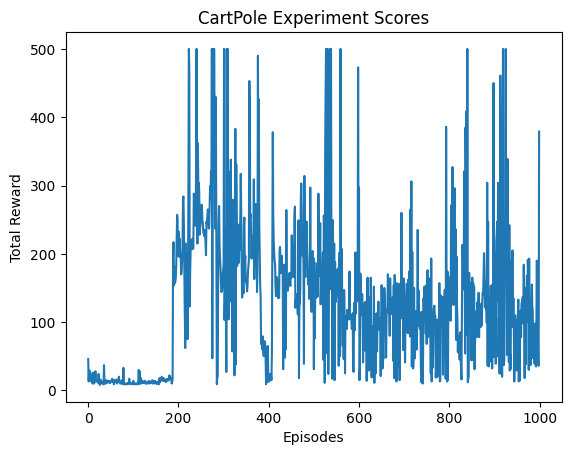


Experiment: 24
Replay Buffer Size: 1000, Buffer Saturation: 0.5, Interval: 500, Epsilon: 0.1, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 19.36
Episode: 100, Running Average (last 50 episodes): 12.76
Episode: 150, Running Average (last 50 episodes): 142.08
Episode: 200, Running Average (last 50 episodes): 195.34
Episode: 250, Running Average (last 50 episodes): 214.46
Episode: 300, Running Average (last 50 episodes): 284.86
Episode: 350, Running Average (last 50 episodes): 272.48
Episode: 400, Running Average (last 50 episodes): 297.38
Episode: 450, Running Average (last 50 episodes): 304.96
Episode: 500, Running Average (last 50 episodes): 380.58
Episode: 550, Running Average (last 50 episodes): 320.16
Episode: 600, Running Average (last 50 episodes): 223.42
Episode: 650, Running Average (last 50 episodes): 258.46
Episode: 700, Running Average (last 50 episodes): 383.04
Episode: 750, Running Average (last 50 episodes): 354.92
Episode: 800, Running Average (last 50 ep

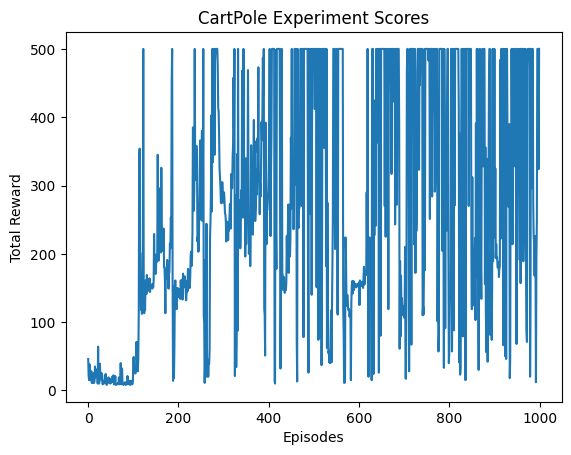


Experiment: 25
Replay Buffer Size: 1000, Buffer Saturation: 0.9, Interval: 100, Epsilon: 0.001, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 104.46
Episode: 100, Running Average (last 50 episodes): 261.74
Episode: 150, Running Average (last 50 episodes): 225.18
Episode: 200, Running Average (last 50 episodes): 185.24
Episode: 250, Running Average (last 50 episodes): 133.18
Episode: 300, Running Average (last 50 episodes): 141.72
Episode: 350, Running Average (last 50 episodes): 218.16
Episode: 400, Running Average (last 50 episodes): 203.62
Episode: 450, Running Average (last 50 episodes): 176.22
Episode: 500, Running Average (last 50 episodes): 154.8
Episode: 550, Running Average (last 50 episodes): 159.18
Episode: 600, Running Average (last 50 episodes): 162.32
Episode: 650, Running Average (last 50 episodes): 158.94
Episode: 700, Running Average (last 50 episodes): 132.04
Episode: 750, Running Average (last 50 episodes): 164.3
Episode: 800, Running Average (last 50 e

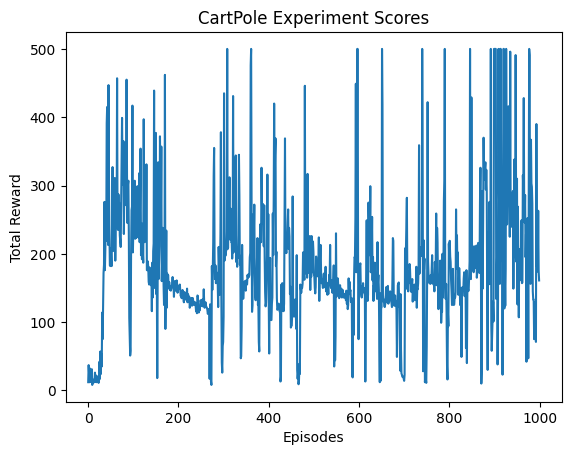


Experiment: 26
Replay Buffer Size: 1000, Buffer Saturation: 0.9, Interval: 100, Epsilon: 0.001, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 88.44
Episode: 100, Running Average (last 50 episodes): 133.42
Episode: 150, Running Average (last 50 episodes): 212.76
Episode: 200, Running Average (last 50 episodes): 291.18
Episode: 250, Running Average (last 50 episodes): 378.4
Episode: 300, Running Average (last 50 episodes): 322.98
Episode: 350, Running Average (last 50 episodes): 242.9
Episode: 400, Running Average (last 50 episodes): 303.82
Episode: 450, Running Average (last 50 episodes): 297.5
Episode: 500, Running Average (last 50 episodes): 111.8
Episode: 550, Running Average (last 50 episodes): 154.84
Episode: 600, Running Average (last 50 episodes): 362.18
Episode: 650, Running Average (last 50 episodes): 398.18
Episode: 700, Running Average (last 50 episodes): 342.86
Episode: 750, Running Average (last 50 episodes): 440.76
Episode: 800, Running Average (last 50 epi

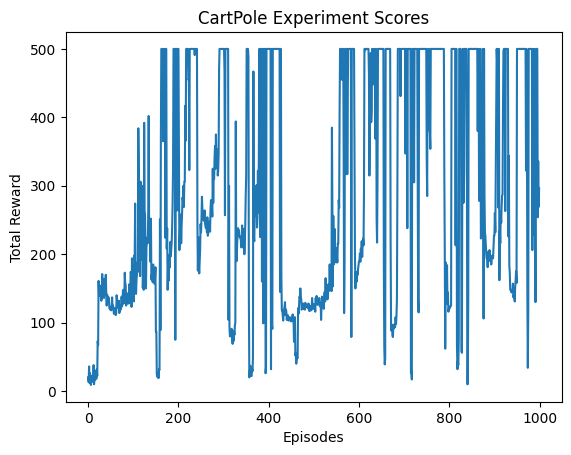


Experiment: 27
Replay Buffer Size: 1000, Buffer Saturation: 0.9, Interval: 100, Epsilon: 0.1, Gamma: 0.9
Episode: 50, Running Average (last 50 episodes): 17.38
Episode: 100, Running Average (last 50 episodes): 199.22
Episode: 150, Running Average (last 50 episodes): 172.44
Episode: 200, Running Average (last 50 episodes): 173.12
Episode: 250, Running Average (last 50 episodes): 136.66
Episode: 300, Running Average (last 50 episodes): 209.78
Episode: 350, Running Average (last 50 episodes): 176.26
Episode: 400, Running Average (last 50 episodes): 135.56
Episode: 450, Running Average (last 50 episodes): 154.08
Episode: 500, Running Average (last 50 episodes): 102.36
Episode: 550, Running Average (last 50 episodes): 125.94
Episode: 600, Running Average (last 50 episodes): 123.62
Episode: 650, Running Average (last 50 episodes): 118.88
Episode: 700, Running Average (last 50 episodes): 115.18
Episode: 750, Running Average (last 50 episodes): 160.54
Episode: 800, Running Average (last 50 ep

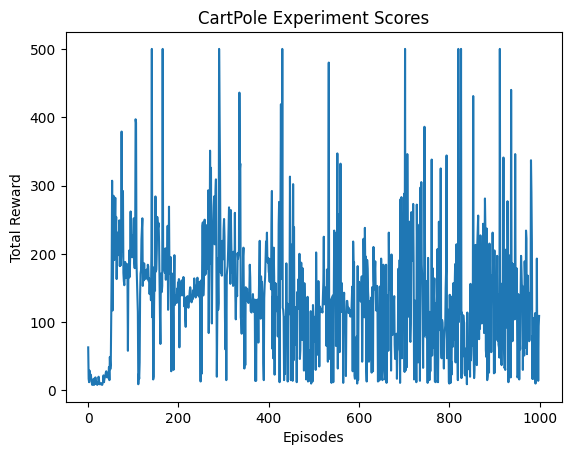


Experiment: 28
Replay Buffer Size: 1000, Buffer Saturation: 0.9, Interval: 100, Epsilon: 0.1, Gamma: 0.99
Episode: 50, Running Average (last 50 episodes): 114.66
Episode: 100, Running Average (last 50 episodes): 204.16
Episode: 150, Running Average (last 50 episodes): 236.06
Episode: 200, Running Average (last 50 episodes): 301.62
Episode: 250, Running Average (last 50 episodes): 235.32
Episode: 300, Running Average (last 50 episodes): 349.78
Episode: 350, Running Average (last 50 episodes): 333.24
Episode: 400, Running Average (last 50 episodes): 291.44
Episode: 450, Running Average (last 50 episodes): 279.08
Episode: 500, Running Average (last 50 episodes): 300.84
Episode: 550, Running Average (last 50 episodes): 333.7
Episode: 600, Running Average (last 50 episodes): 363.92
Episode: 650, Running Average (last 50 episodes): 317.38
Episode: 700, Running Average (last 50 episodes): 396.34
Episode: 750, Running Average (last 50 episodes): 186.8


In [ ]:
#running the cartpole experiments

agents = []
num_episodes = 1000 #testing 1000 training episodes

#Only doing 2 experiments per lever since doing the three that I chose initially took the entire weekend and was kicked out by
#google before finishing

# Experiment with adjusting the size of the replay buffer for training

replay_buffer_sizes = [100, 1000] # test when the buffer is 10%, 50%, and 100% of the number of episodes

# how often the old records are deleted from the replay buffer

buffer_saturations = [.5, .90] #the buffer starts removing old data when it is 50% full, and 80% full

# the interval between each update of the target neural network

intervals = [100, 500] # update every 10th, every 25th, and every 50th episode

# and the usual Q learning parameters

epsilons = [0.001, 0.1]
gammas = [0.9, 0.99]

experiment = 0
for replay_buffer_size in replay_buffer_sizes:
  for buffer_saturation in buffer_saturations:
    for interval in intervals:
      for epsilon in epsilons:
        for gamma in gammas:
          experiment += 1
          print(f"\nExperiment: {experiment}\nReplay Buffer Size: {replay_buffer_size}, Buffer Saturation: {buffer_saturation}, Interval: {interval}, Epsilon: {epsilon}, Gamma: {gamma}")
          agent = run_cartpole_experiment(num_episodes, 0.001, gamma, replay_buffer_size, buffer_saturation, 64, 1.0, 0.995, epsilon, interval) #keeping a constant
          agents.append((agent, f"Replay Buffer Size: {replay_buffer_size}, Buffer Saturation: {buffer_saturation}, Interval: {interval}, Epsilon: {epsilon}, Gamma: {gamma}"))

#run the experiments and show the graphs, while storing the agents for later.


In [ ]:
def cartpole_performance(agents):

  scores = []

  for agent_pair in agents:
    agent = agent_pair[0]
    agent_name = agent_pair[1]

    env = gym.make('CartPole-v1')
    state = env.reset()

    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward

    scores.append([total_reward, agent_name])

  sorted_scores = sorted(scores, key=lambda x: x[0], reverse=True)

  return sorted_scores


scores = cartpole_performance(agents)

for score in scores:
  print(f"Cartpole Agent - {score[1]}:\n    Post Training Score:{score[0]}\n")

Looking at the experiments while running, I can definitively say that having the buffer size set to the entirety of the training episodes raised the performance of the agents a lot.

Took less than half a minute for training the experiments up to around experiment 162, at which point the buffer was increased and it started to take longer as the episodes became more successful.

## Blackjack Experiments

In [ ]:
def run_blackjack_experiment(num_episodes, learning_rate=0.001, gamma=0.99, buffer_capacity=5000, buffer_saturation=.99, batch_size=64, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, update_target_freq=1000):

  # Blackjack Experiments
  env_blackjack = gym.make('Blackjack-v1')
  agent_blackjack = DDQNAgent(env_blackjack, 3,
                            learning_rate=learning_rate,
                            gamma=gamma,
                            buffer_capacity=buffer_capacity,
                            buffer_saturation=buffer_saturation,
                            batch_size=batch_size,
                            epsilon=epsilon,
                            epsilon_decay=epsilon_decay,
                            epsilon_min=epsilon_min,
                            update_target_freq=update_target_freq)


  print("Running blackjack, Printing update every 1000th episode.")

  scores_blackjack = np.array([])

  for episode in range(1, num_episodes+1):
      state = env_blackjack.reset()
      done = False
      total_reward_blackjack = 0
      while not done:
          action = agent_blackjack.act(state)
          next_state, reward, done, _ = env_blackjack.step(action)
          agent_blackjack.buffer.push(state, action, reward, next_state, done)
          agent_blackjack.learn()
          state = next_state
          total_reward_blackjack += reward

      scores_blackjack = np.append(scores_blackjack, total_reward_blackjack)

      avg = sum(scores_blackjack) / len(scores_blackjack)

      if episode % 1000 == 0:
        # For the experiments, I'm running 50000 training episodes for each experimental setup, so I'll only print every 2000th episode
          print(f"Episode: {episode}, Total Reward Running Average: {avg}")


  env_blackjack.close()

  #not as much value in graphing the blackjack data, so I'll just use the averages I'll calculate later.

  return agent_blackjack

In [ ]:
#running the blackjack experiments

# Replay buffer size: 1000, 5000, 10000
# Buffer saturation: 0.5, 0.9, 0.1
# Interval: 1000, 2500, 100
# Epsilon 0.01, 0.1, 0.001


blackjack_agents = []
num_episodes = 10000

# Experiment with adjusting the size of the replay buffer for training,

replay_buffer_sizes = [1000, 5000, 10000] # test when the buffer is 10%, 50%, and 100% of the number of episodes

# how often the old records are deleted from the replay buffer,

buffer_saturations = [.1, .5, .90] #the buffer starts removing old data when it is 10% full, 50% full, and 90% full

# the interval between each update of the target neural network,

intervals = [100, 1000, 2500] # update every 100th, every 1000th, and every 2500th episode

# and the usual Q learning parameters

epsilons = [0.001, 0.01, 0.1]
gammas = [0.9, 0.95, 0.99]

experiment = 0

for replay_buffer_size in replay_buffer_sizes:
  for buffer_saturation in buffer_saturations:
    for interval in intervals:
      for epsilon in epsilons:
        for gamma in gammas:
          experiment += 1 #meant to print this, but I suppose it didn't save or something.

          print(f"Experiment: {experiment}")

          agent = run_blackjack_experiment(num_episodes, 0.001, gamma, replay_buffer_size, buffer_saturation, 64, 1.0, 0.995, epsilon, interval) #keeping a constant
          blackjack_agents.append((agent, [replay_buffer_size, buffer_saturation, interval, epsilon, gamma]))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Running blackjack, Printing update every 1000th episode.
Episode: 1000, Total Reward Running Average: -0.15
Episode: 2000, Total Reward Running Average: -0.13
Episode: 3000, Total Reward Running Average: -0.11733333333333333
Episode: 4000, Total Reward Running Average: -0.10725
Episode: 5000, Total Reward Running Average: -0.0992
Episode: 6000, Total Reward Running Average: -0.0945
Episode: 7000, Total Reward Running Average: -0.09
Episode: 8000, Total Reward Running Average: -0.089625
Episode: 9000, Total Reward Running Average: -0.08744444444444445
Episode: 10000, Total Reward Running Average: -0.0892
Running blackjack, Printing update every 1000th episode.
Episode: 1000, Total Reward Running Average: -0.133
Episode: 2000, Total Reward Running Average: -0.0965
Episode: 3000, Total Reward Running Average: -0.083
Episode: 4000, Total Reward Running Average: -0.08275
Episode: 5000, Total Reward Running Average: -0.0732
Episode: 6000, Total Reward Running Average: -0.06583333333333333
Ep

In [ ]:
def avg_blackjack_performance(agents):

  scores = []

  for agent_pair in agents:
    agent = agent_pair[0]
    agent_name = agent_pair[1]

    a_score = 0

    env = gym.make('Blackjack-v1')
    state = env.reset()

    for episode in range(1, 100+1):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward

        a_score += total_reward

    # print(a_score)
    # print(agent_name)

    result = [(a_score/100), agent_name]

    scores.append(result)


  # print(scores)
  sorted_scores = sorted(scores, key=lambda x: x[0], reverse=True)

  return sorted_scores


# print(blackjack_agents)

scores = avg_blackjack_performance(blackjack_agents)

# print(scores)

f"Replay Buffer Size: {replay_buffer_size}, Buffer Saturation: {buffer_saturation}, Interval: {interval}, Epsilon: {epsilon}, Gamma: {gamma}"

for score in scores:
  print(f"Blackjack Agent - Replay Buffer Size: {score[1][0]}, Buffer Saturation: {score[1][1]}, Interval: {score[1][2]}, Epsilon: {score[1][3]}, Gamma: {score[1][4]}:\n    Avg Score:{score[0]}\n")

[[0.2, [1000, 0.5, 1000, 0.01, 0.99]], [0.19, [1000, 0.9, 2500, 0.1, 0.99]], [0.16, [5000, 0.5, 2500, 0.01, 0.9]], [0.14, [10000, 0.1, 1000, 0.001, 0.95]], [0.13, [10000, 0.1, 100, 0.01, 0.9]], [0.1, [10000, 0.1, 2500, 0.01, 0.99]], [0.09, [1000, 0.1, 1000, 0.001, 0.95]], [0.09, [1000, 0.1, 2500, 0.1, 0.9]], [0.09, [1000, 0.5, 2500, 0.001, 0.95]], [0.09, [10000, 0.9, 100, 0.01, 0.99]], [0.08, [10000, 0.5, 1000, 0.001, 0.9]], [0.07, [1000, 0.1, 2500, 0.01, 0.9]], [0.07, [1000, 0.5, 1000, 0.01, 0.9]], [0.07, [1000, 0.5, 2500, 0.01, 0.9]], [0.07, [1000, 0.5, 2500, 0.01, 0.99]], [0.07, [5000, 0.1, 2500, 0.01, 0.99]], [0.07, [5000, 0.5, 1000, 0.001, 0.95]], [0.06, [1000, 0.9, 2500, 0.001, 0.99]], [0.06, [5000, 0.9, 100, 0.001, 0.9]], [0.06, [10000, 0.1, 100, 0.01, 0.99]], [0.06, [10000, 0.1, 2500, 0.01, 0.9]], [0.05, [5000, 0.1, 1000, 0.001, 0.95]], [0.05, [5000, 0.1, 2500, 0.01, 0.95]], [0.05, [5000, 0.9, 100, 0.01, 0.9]], [0.05, [5000, 0.9, 2500, 0.01, 0.99]], [0.05, [10000, 0.9, 2500, 0.

Currently waiting for the results, but it should be a sorted list of the blackjack actors sorted by their average score.

Takes a long time to run all the experiments, so I'll add in my previous results for blackjack after this is done running.


### DQN Training Comparison

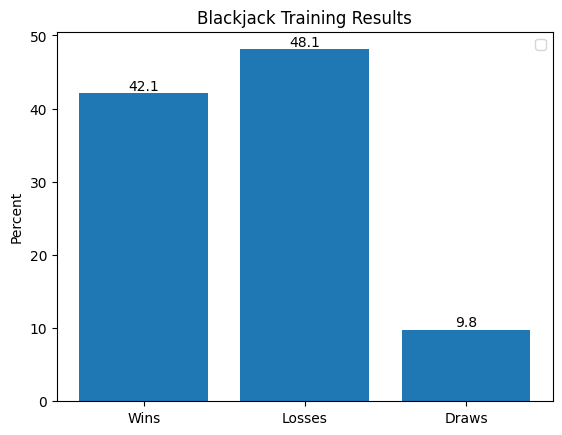